## Approach 

In [7]:
#!pip install nltk


In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
import s3fs
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

# ---------------------
# Step 1: Load Data
# ---------------------
fs = s3fs.S3FileSystem()

resume_df = pd.read_parquet(
    's3://group-6-resume-preprocessing/hive_export/resumes/000000_0-hadoop_20250403011440_9f04e66f-5b4f-4a4a-9eec-883d8ed76fb2-1',
    filesystem=fs
)
resume_df.columns = ['resumeID', 'category', 'resume']

job_df = pd.read_parquet(
    's3://group-6-resume-preprocessing/hive_export/standardized_job_listings/000000_0-hadoop_20250403003123_1681fb76-9adb-4370-9a1c-5ab7d1d925d9-1',
    filesystem=fs
)
job_df.columns = [
    'job_posting_id', 'job_title', 'company_name', 'job_location',
    'job_seniority_level', 'job_employment_type', 'job_industries',
    'job_summary', 'job_num_applicants', 'job_posted_date',
    'job_posted_time', 'job_posted_year', 'job_posted_month'
]


In [3]:
import re
from nltk.corpus import stopwords

# Load NLTK English stop words
nltk_stopwords = set(stopwords.words('english'))

def nltk_preprocessor(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and digits
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove stop words
    words = [word for word in text.split() if word not in nltk_stopwords]
    return ' '.join(words)


In [4]:

# ---------------------
# Step 2: TF-IDF Features
# ---------------------
combined_texts = pd.concat([resume_df['resume'], job_df['job_summary']], axis=0).astype(str)
vectorizer = TfidfVectorizer(max_features=1000, preprocessor=nltk_preprocessor)
vectorizer.fit(combined_texts)

resume_tfidf = vectorizer.transform(resume_df['resume'].astype(str))
job_tfidf = vectorizer.transform(job_df['job_summary'].astype(str))


In [7]:
from fuzzywuzzy import fuzz
# ---------------------
# Step 3: Create Resume-Job Pairs
# ---------------------
pairs = list(itertools.product(range(len(resume_df)), range(len(job_df))))
rows = []

for r_idx, j_idx in pairs:
    res_vec = resume_tfidf[r_idx]
    job_vec = job_tfidf[j_idx]

    cosine_sim = cosine_similarity(res_vec, job_vec)[0][0]
    tfidf_overlap = res_vec.multiply(job_vec).sum()

    category = resume_df.iloc[r_idx]['category'].lower()
    job_text = (job_df.iloc[j_idx]['job_title'] + " " + job_df.iloc[j_idx]['job_summary']).lower()
    fuzzy_score = fuzz.token_set_ratio(category, job_text)

    is_match = int(fuzzy_score >= 50)
    #is_match= int(cosine_sim >= 0.25)  # adjustable threshold
    rows.append([
        resume_df.iloc[r_idx]['resumeID'],
        resume_df.iloc[r_idx]['category'],
        resume_df.iloc[r_idx]['resume'],
        job_df.iloc[j_idx]['job_posting_id'],
        job_df.iloc[j_idx]['job_title'],
        job_df.iloc[j_idx]['job_summary'],
        cosine_sim,
        tfidf_overlap,
        is_match
    ])

df = pd.DataFrame(rows, columns=[
    'Resume_ID', 'Resume_Category', 'Resume_Summary',
    'Job_ID', 'Job_Title', 'Job_Description',
    'cosine_similarity', 'tfidf_overlap', 'ISmatch'
])

df.head()

/opt/conda/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


,Resume_ID,Resume_Category,Resume_Summary,Job_ID,Job_Title,Job_Description,cosine_similarity,tfidf_overlap,ISmatch
0,"""Res001""","""Data Science""","""Skills Programming Languages Python pandas nu...",221596840,Social Media Marketing Coordinator,Social Media Marketing Coordinator Mangawhai N...,0.076773,0.076773,0
1,"""Res001""","""Data Science""","""Skills Programming Languages Python pandas nu...",3250320651,Senior Consultant IT Regulatory Risk Risikoman...,Du machst den Unterschied Ob im Business Audit...,0.035152,0.035152,1
2,"""Res001""","""Data Science""","""Skills Programming Languages Python pandas nu...",3551181273,Consultant Accounting Internal Controls mwd in...,Du machst den Unterschied Ob im Business Audit...,0.020392,0.020392,1
3,"""Res001""","""Data Science""","""Skills Programming Languages Python pandas nu...",3682021118,Senior Analyst KYC,Job Description The ideal candidate must posse...,0.120791,0.120791,1
4,"""Res001""","""Data Science""","""Skills Programming Languages Python pandas nu...",3710198848,SALES FLOOR ASSOCIATE,Store Dollar Tree Dollar Tree is seeking motiv...,0.052861,0.052861,0


In [9]:

# ---------------------
# Step 4: Add More Features
# ---------------------
df['resume_length'] = df['Resume_Summary'].str.len()
df['job_length'] = df['Job_Description'].str.len()

# ---------------------
# Step 5: Filter Noisy Positives
# ---------------------
df = df[~((df['cosine_similarity'] < 0.25) & (df['ISmatch'] == 1))]

# ---------------------
# Step 6: Prepare Training Data
# ---------------------
X = df[['Resume_Category','Job_Title','resume_length', 'job_length']]
y = df['ISmatch']

for col in ['Resume_Category', 'Job_Title']:
    X[col] = X[col].astype('category')
# Handle imbalance
scale_ratio = len(y[y == 0]) / (len(y[y == 1]) + 1e-5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_ratio, enable_categorical=True)
model.fit(X_train, y_train)




/tmp/ipykernel_117/2546608828.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
/tmp/ipykernel_117/2546608828.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [03:12:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [10]:
# ---------------------
# Step 7: Predict + Output
# ---------------------

import numpy as np
from sklearn.metrics import accuracy_score

# Compute predicted probabilities and round them
df['matching_score'] = np.round(model.predict_proba(X)[:, 1], 2)
# Get the binary predictions from the model
df['ISmatch_pred'] = model.predict(X)

# Convert the continuous matching_score into binary predictions using a threshold (e.g., 0.5)
threshold = 0.5  # Adjust as necessary based on your model
df['matching_score_binary'] = (df['matching_score'] >= threshold).astype(int)

# Final output DataFrame
final = df[[
    'Resume_ID', 'Resume_Category', 'Resume_Summary',
    'Job_ID', 'Job_Title', 'Job_Description',
    'cosine_similarity', 'tfidf_overlap', 'resume_length', 'job_length',
    'ISmatch', 'ISmatch_pred', 'matching_score', 'matching_score_binary'
]]

# Compute and print the tuned model accuracy using the binary predictions
accuracy = accuracy_score(y, df['matching_score_binary'])
print(f"✅ Tuned Model Accuracy: {accuracy:.2f}")

✅ Tuned Model Accuracy: 1.00


In [11]:
final.head(25)

,Resume_ID,Resume_Category,Resume_Summary,Job_ID,Job_Title,Job_Description,cosine_similarity,tfidf_overlap,resume_length,job_length,ISmatch,ISmatch_pred,matching_score,matching_score_binary
0,"""Res001""","""Data Science""","""Skills Programming Languages Python pandas nu...",221596840,Social Media Marketing Coordinator,Social Media Marketing Coordinator Mangawhai N...,0.076773,0.076773,4505,1515,0,0,0.00,0
4,"""Res001""","""Data Science""","""Skills Programming Languages Python pandas nu...",3710198848,SALES FLOOR ASSOCIATE,Store Dollar Tree Dollar Tree is seeking motiv...,0.052861,0.052861,4505,1607,0,0,0.00,0
5,"""Res001""","""Data Science""","""Skills Programming Languages Python pandas nu...",3726259972,Chef de projet digital domaine bancaire HF,Qui sommes nous EuroInformation filiale techno...,0.008566,0.008566,4505,3972,0,0,0.00,0
6,"""Res001""","""Data Science""","""Skills Programming Languages Python pandas nu...",3726753302,Senior Manager Financial Services Credit mwd i...,Du machst den Unterschied Ob im Business Audit...,0.014126,0.014126,4505,4454,0,0,0.00,0
7,"""Res001""","""Data Science""","""Skills Programming Languages Python pandas nu...",3728187710,Bygningskonstruktr,Bygningskonstruktr med passion for renovering ...,0.000541,0.000541,4505,1213,0,0,0.00,0
8,"""Res001""","""Data Science""","""Skills Programming Languages Python pandas nu...",3733038708,DevOps Engineer Application Management all gen...,Wir gehren zu den TopAdressen in der ITWelt un...,0.008304,0.008304,4505,3733,0,0,0.00,0
10,"""Res001""","""Data Science""","""Skills Programming Languages Python pandas nu...",3905525636,Regional Account Manager,When you join Trend you become part of a uniqu...,0.175416,0.175416,4505,4636,0,0,0.00,0
12,"""Res001""","""Data Science""","""Skills Programming Languages Python pandas nu...",3918942089,Rechtsanwlte mwd Investmentrecht Private Funds,Arbeiten im optimalen Gleichgewicht Zwischen H...,0.000550,0.000550,4505,946,0,0,0.00,0
14,"""Res001""","""Data Science""","""Skills Programming Languages Python pandas nu...",3929754212,Wireless Sales Pro,General Information Company PREUS Location BEN...,0.031380,0.031380,4505,2935,0,0,0.06,0
15,"""Res001""","""Data Science""","""Skills Programming Languages Python pandas nu...",3944508829,Sales Development Representative stage,Sales Development Representative Stage Senti d...,0.006767,0.006767,4505,2777,0,0,0.00,0


In [12]:
# To save to S3:
final.to_csv('s3://group-6-resume-preprocessing/output/resume_job_matching_results.csv', index=False)
print("📁 File saved as: resume_job_matching_results_tuned.csv")

📁 File saved as: resume_job_matching_results_tuned.csv


In [23]:
print(final.head(1))

  Resume_ID Resume_Category  \
0  "Res001"  "Data Science"   

                                      Resume_Summary     Job_ID  \
0  "Skills Programming Languages Python pandas nu...  221596840   

                            Job_Title  \
0  Social Media Marketing Coordinator   

                                     Job_Description  cosine_similarity  \
0  Social Media Marketing Coordinator Mangawhai N...           0.076773   

   tfidf_overlap  resume_length  job_length  ISmatch  ISmatch_pred  \
0       0.076773           4505        1515        0             0   

   matching_score  matching_score_binary  
0             0.0                      0  


In [140]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


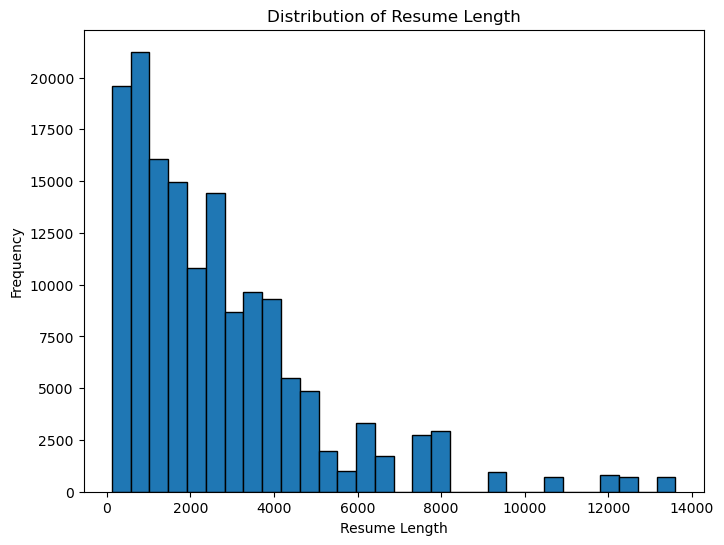

In [141]:
plt.figure(figsize=(8, 6))
plt.hist(final['resume_length'].dropna(), bins=30, edgecolor='black')
plt.title('Distribution of Resume Length')
plt.xlabel('Resume Length')
plt.ylabel('Frequency')
plt.show()

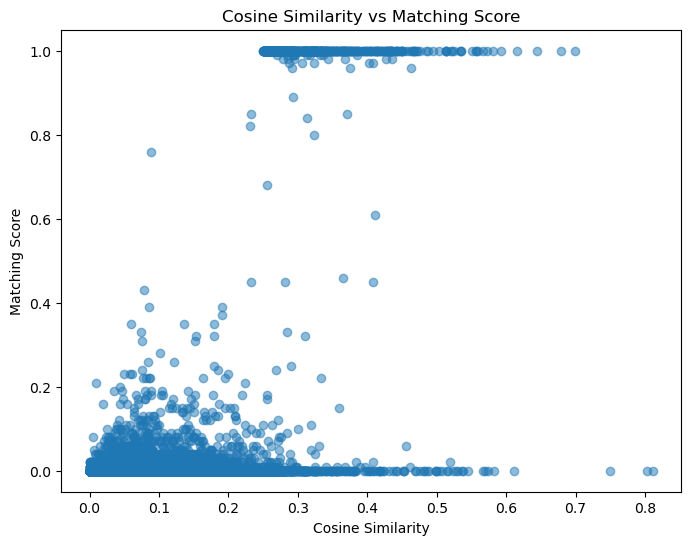

In [143]:
plt.figure(figsize=(8, 6))
plt.scatter(final['cosine_similarity'], final['matching_score'], alpha=0.5)
plt.title('Cosine Similarity vs Matching Score')
plt.xlabel('Cosine Similarity')
plt.ylabel('Matching Score')
plt.show()

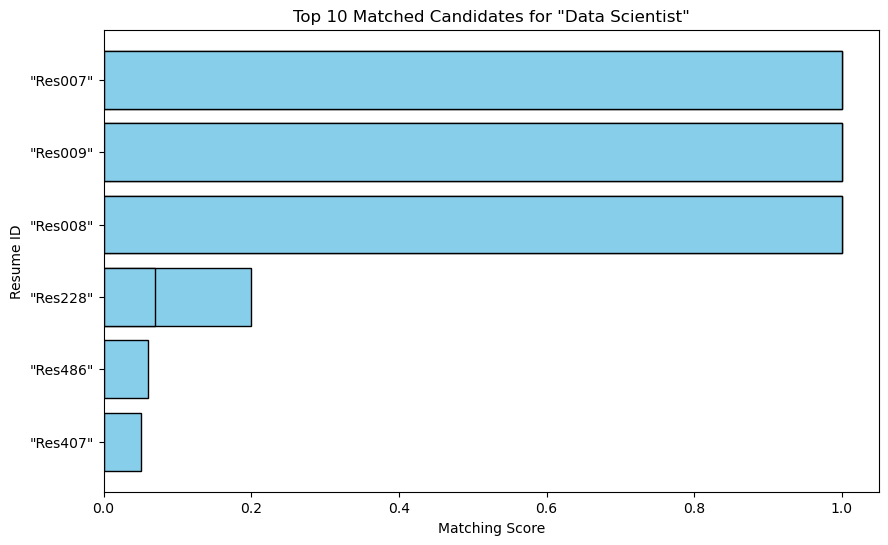

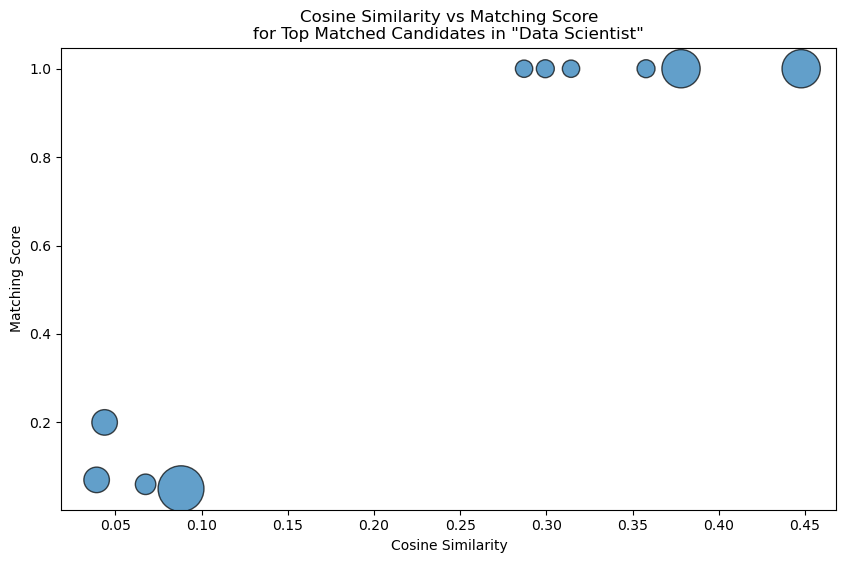

In [146]:
# Example: Define the target job category (e.g., Data Scientist)
job_category = 'Data Scientist'

# -----------------------------
# Step 1: Filter the DataFrame for a specific job category
# -----------------------------
# This filters rows where the Job_Title contains the target job category.
filtered = final[final['Job_Title'].str.contains(job_category, case=False, na=False)]

# -----------------------------
# Step 2: Sort by matching_score and select top N candidates
# -----------------------------
top_n = 10  # Define how many top candidates you want to display
top_matched = filtered.sort_values(by='matching_score', ascending=False).head(top_n)

# Check if there are any records after filtering
if top_matched.empty:
    print(f"No candidates found for job category: {job_category}")
else:
    # -----------------------------
    # Visualization 1: Horizontal Bar Chart of Top Matched Candidates
    # -----------------------------
    plt.figure(figsize=(10, 6))
    # Using Resume_ID for identification; convert to string if needed.
    plt.barh(top_matched['Resume_ID'].astype(str), top_matched['matching_score'], color='skyblue', edgecolor='black')
    plt.xlabel('Matching Score')
    plt.ylabel('Resume ID')
    plt.title(f'Top {top_n} Matched Candidates for "{job_category}"')
    plt.gca().invert_yaxis()  # Optional: inverts the y-axis so that highest score is at the top
    plt.show()

    # -----------------------------
    # Visualization 2: Scatter Plot of Cosine Similarity vs Matching Score
    # -----------------------------
    plt.figure(figsize=(10, 6))
    # Use bubble sizes scaled by resume_length to provide additional context.
    bubble_sizes = top_matched['resume_length'] / 10  # Adjust scaling factor as needed
    plt.scatter(top_matched['cosine_similarity'], top_matched['matching_score'],
                s=bubble_sizes, alpha=0.7, edgecolor='black')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Matching Score')
    plt.title(f'Cosine Similarity vs Matching Score\nfor Top Matched Candidates in "{job_category}"')
    plt.show()

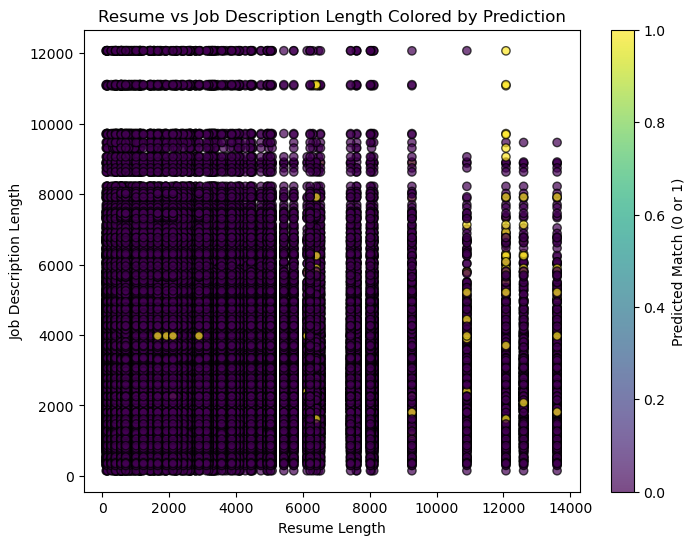

In [147]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(final['resume_length'], final['job_length'],
                      c=final['ISmatch_pred'], cmap='viridis', alpha=0.7, edgecolor='black')
plt.xlabel('Resume Length')
plt.ylabel('Job Description Length')
plt.title('Resume vs Job Description Length Colored by Prediction')
plt.colorbar(scatter, label='Predicted Match (0 or 1)')
plt.show()


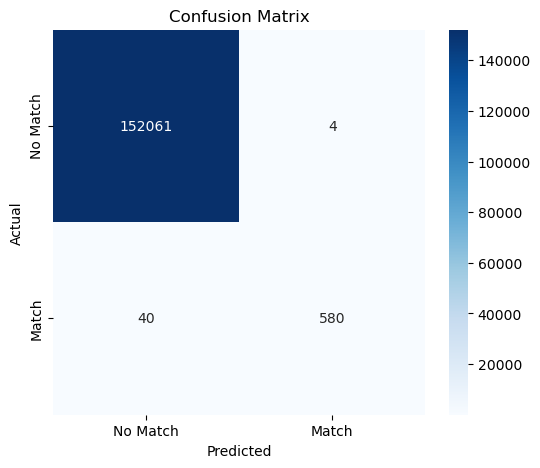

In [149]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
# Compute the confusion matrix
cm = confusion_matrix(final['ISmatch'], final['ISmatch_pred'])
labels = ['No Match', 'Match']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


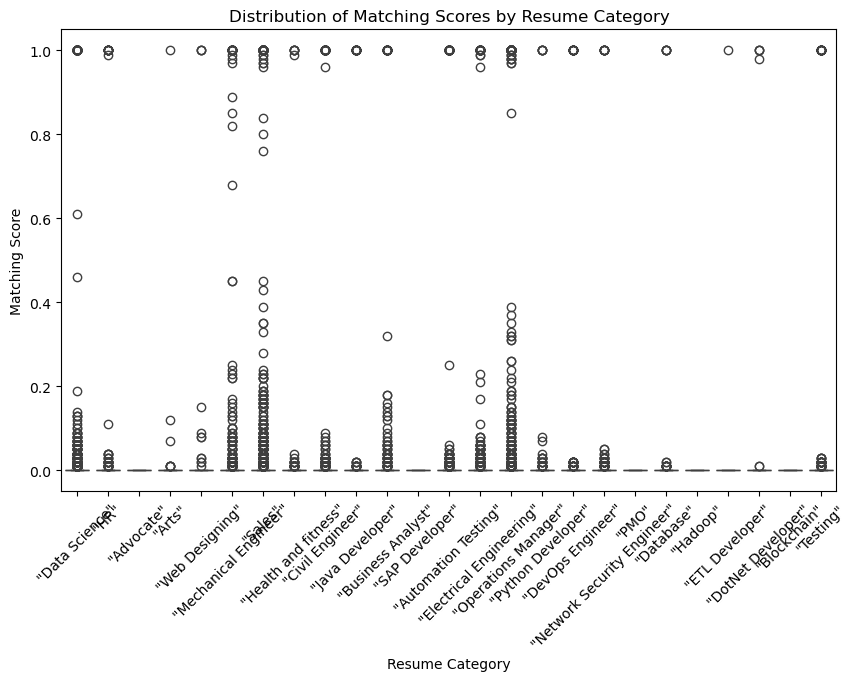

In [150]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Resume_Category', y='matching_score', data=final)
plt.xticks(rotation=45)
plt.title('Distribution of Matching Scores by Resume Category')
plt.xlabel('Resume Category')
plt.ylabel('Matching Score')
plt.show()


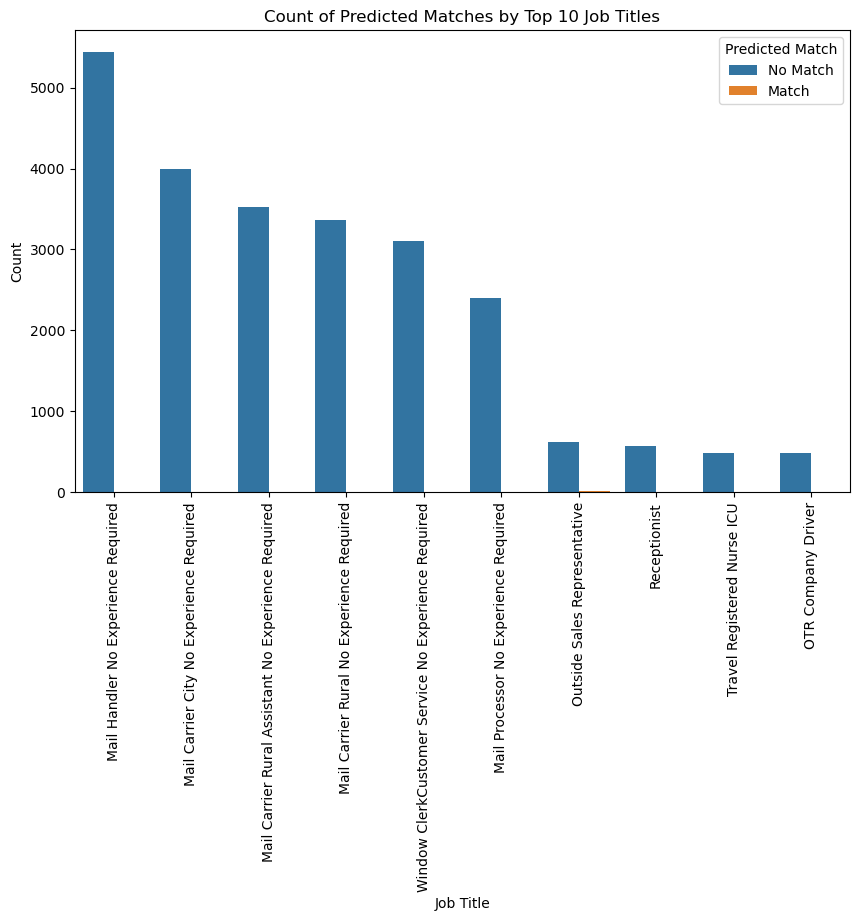

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify the top 10 Job Titles by count.
top_10_jobs = final['Job_Title'].value_counts().head(10).index.tolist()

# Filter the DataFrame to include only the records corresponding to these top 10 job titles.
filtered = final[final['Job_Title'].isin(top_10_jobs)]

plt.figure(figsize=(10, 6))
sns.countplot(x='Job_Title', hue='ISmatch_pred', data=filtered, order=top_10_jobs)
plt.xticks(rotation=90)
plt.title('Count of Predicted Matches by Top 10 Job Titles')
plt.xlabel('Job Title')
plt.ylabel('Count')
plt.legend(title='Predicted Match', labels=['No Match', 'Match'])
plt.show()


In [14]:
import matplotlib as plt
# Define the target job category (e.g., Data Scientist)
job_category = 'Data Scientist'

# Filter rows where 'Job_Title' contains the target job category
filtered = final[final['Job_Title'].str.contains(job_category, case=False, na=False)]

# Count the unique resumes from the filtered DataFrame
num_resumes = filtered['Resume_ID'].nunique()

# Create a simple bar chart to display the count
plt.figure(figsize=(4,6))
plt.bar([job_category], [num_resumes], color='skyblue', edgecolor='black')
plt.ylabel('Number of Resumes')
plt.title(f'Number of Resumes for "{job_category}"')
plt.tight_layout()
plt.show()


AttributeError: module 'matplotlib' has no attribute 'figure'